<a href="https://colab.research.google.com/github/faremi/saheed/blob/master/file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

Machine learning model that classifies statements and questions expressed by university students in Kenya when speaking about the mental health challenges they struggle with. The four categories are depression, suicide, alchoholism, and drug abuse.


Sentiment clasification is based on BERT Model.

BERT:Bidirectional Encoder Representations from Transformers

# Setup

Importing the relevant libraries and getting to know the files

In [1]:
!pip install -qq transformers
!pip install -q -U watermark
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers



import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch

import numpy as np

import pandas as pd

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict

from textwrap import wrap

from torch import nn, optim

from torch.utils.data import Dataset, DataLoader

%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

import nltk
import re
import string
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')



CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
transformers 2.11.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.device(type='cuda', index=0)

device(type='cuda', index=0)

# Data Exploration

We'll load the train and test dataset

In [3]:
train_set = pd.read_csv("/content/drive/My Drive/Zindi/Train.csv")
test_set = pd.read_csv("/content/drive/My Drive/Zindi/Test.csv")

In [4]:
train_set.shape

(616, 3)

In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


Text(0.5, 0, 'Label score')

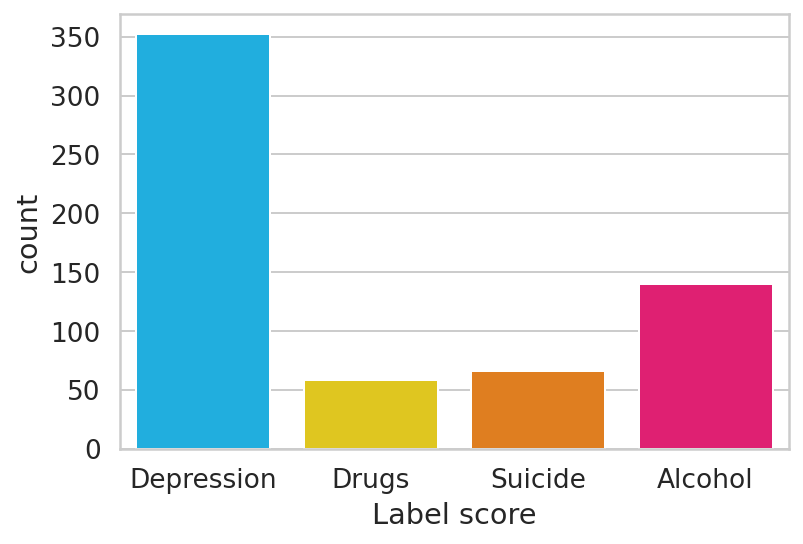

In [6]:
sns.countplot(train_set.label)
plt.xlabel("Label score")

In [7]:
def to_sentiment(rating):
  if rating == "Depression":
    return 0
  elif rating == "Drugs":
    return 1
  elif rating == "Suicide":
    return 2
  elif rating == "Alcohol":
    return 3
  else: 
    return 5

In [8]:
train_set['sentiment'] = train_set.label.apply(to_sentiment)
class_names = ['Depression', 'Drugs', 'Suicide','Alcohol']

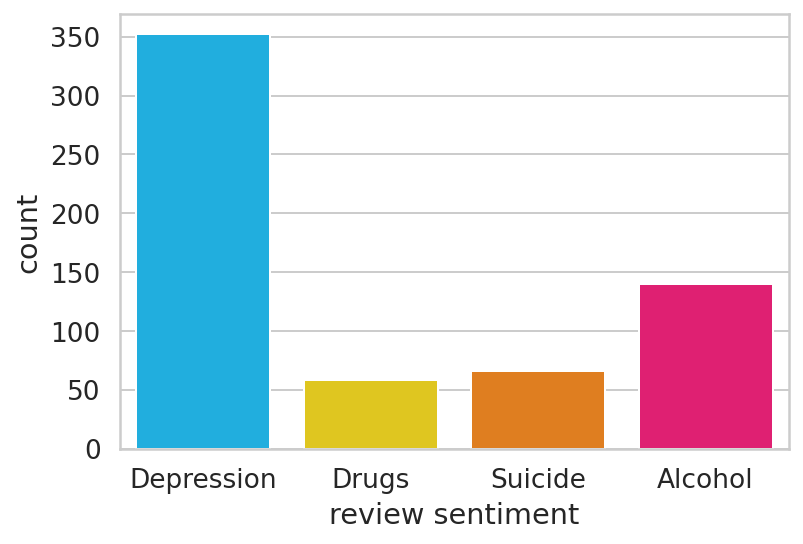

In [9]:
ax = sns.countplot(train_set.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

# Data Preprocessing

In [10]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:

train_set['text'] = train_set['text'].apply(lambda x:clean_text(x))
#text correction
#STOPWORDS = stopwords.words('english')
#def remove_stopwords(text):
#    return [word for word in text.split() if word not in STOPWORDS]
#train_set['text'] = train_set['text'].apply(lambda x : remove_stopwords(x))


In [12]:
train_set.head()

,ID,text,label,sentiment
0,SUAVK39Z,i feel that it was better i dieam happy,Depression,0
1,9JDAGUV3,why do i get hallucinations,Drugs,1
2,419WR1LQ,i am stresseed due to lack of financial suppor...,Depression,0
3,6UY7DX6Q,why is life important,Suicide,2
4,FYC0FTFB,how could i be helped to go through the depres...,Depression,0


In [13]:
PRE_TRAINED_MODEL_NAME = "bert-base-uncased"

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
token_lens = []

for txt in train_set.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

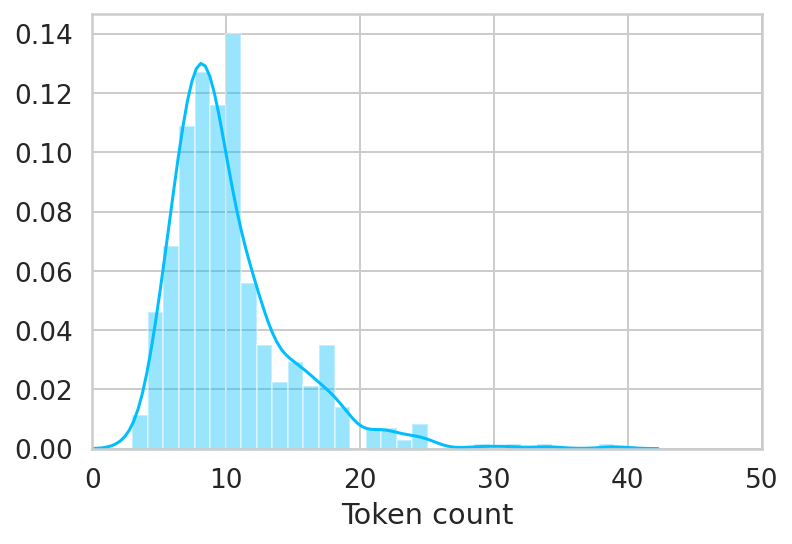

In [16]:
sns.distplot(token_lens)
plt.xlim(0,50)
plt.xlabel('Token count');

In [17]:
MAX_LEN = 50

In [18]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [19]:
df_train, df_test = train_test_split(train_set, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
df_train.shape, df_val.shape, df_test.shape

((492, 4), (99, 4), (25, 4))

In [21]:
def create_data_loader(train_set, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=train_set.text.to_numpy(),
    targets=train_set.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [22]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [24]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50])
torch.Size([16, 50])
torch.Size([16])


# Sentiment Classification with BERT and Hugging Face

In [25]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [26]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [27]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [28]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [29]:
bert_model.config.hidden_size

768

In [30]:
pooled_output.shape

torch.Size([1, 768])

In [31]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [32]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 50])
torch.Size([16, 50])


In [34]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4269, 0.2739, 0.2045, 0.0947],
        [0.2649, 0.1593, 0.4599, 0.1159],
        [0.3580, 0.2136, 0.2988, 0.1296],
        [0.2863, 0.2751, 0.3164, 0.1222],
        [0.3540, 0.3245, 0.1674, 0.1541],
        [0.2640, 0.2189, 0.3758, 0.1413],
        [0.3378, 0.3454, 0.2112, 0.1056],
        [0.3970, 0.2249, 0.2887, 0.0894],
        [0.2601, 0.1422, 0.5016, 0.0962],
        [0.3208, 0.2475, 0.3483, 0.0834],
        [0.2233, 0.2066, 0.4669, 0.1032],
        [0.3394, 0.2456, 0.3158, 0.0992],
        [0.2611, 0.2677, 0.3309, 0.1404],
        [0.3259, 0.2712, 0.3081, 0.0948],
        [0.3526, 0.2024, 0.2460, 0.1991],
        [0.2639, 0.1946, 0.3327, 0.2088]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

# Training

In [35]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [36]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [38]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.9598825785421556 accuracy 0.628048780487805
Val   loss 0.708940863609314 accuracy 0.7272727272727273

Epoch 2/5
----------
Train loss 0.5241819538416401 accuracy 0.8109756097560976
Val   loss 0.5194919747965676 accuracy 0.7676767676767677

Epoch 3/5
----------
Train loss 0.3101397555681967 accuracy 0.8963414634146343
Val   loss 0.43327867665461134 accuracy 0.8383838383838385

Epoch 4/5
----------
Train loss 0.20488869759344286 accuracy 0.9451219512195123
Val   loss 0.42877726203628946 accuracy 0.8282828282828284

Epoch 5/5
----------
Train loss 0.16554070636630058 accuracy 0.9593495934959351
Val   loss 0.41368792951107025 accuracy 0.8383838383838385

CPU times: user 37.7 s, sys: 20.2 s, total: 57.9 s
Wall time: 1min 1s


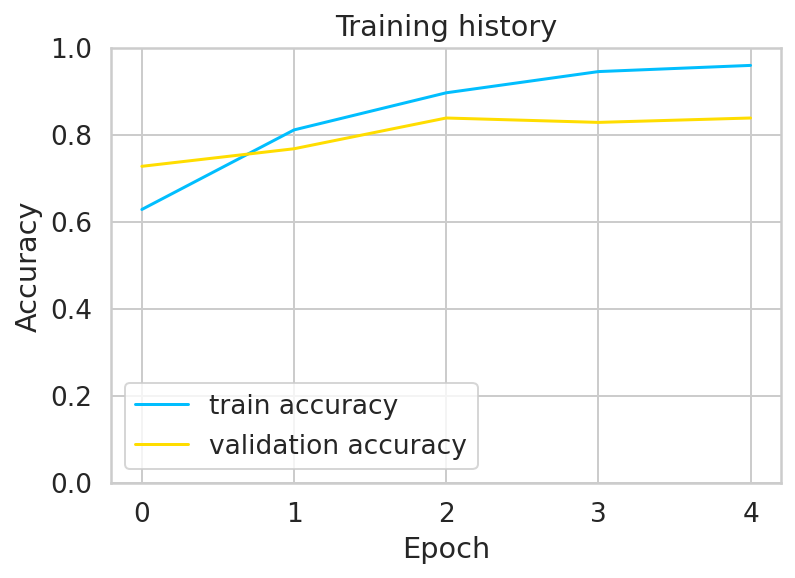

In [39]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [40]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.88

In [41]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [42]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

  Depression       0.92      0.92      0.92        13
       Drugs       1.00      0.67      0.80         3
     Suicide       0.50      0.50      0.50         2
     Alcohol       0.88      1.00      0.93         7

    accuracy                           0.88        25
   macro avg       0.82      0.77      0.79        25
weighted avg       0.89      0.88      0.88        25



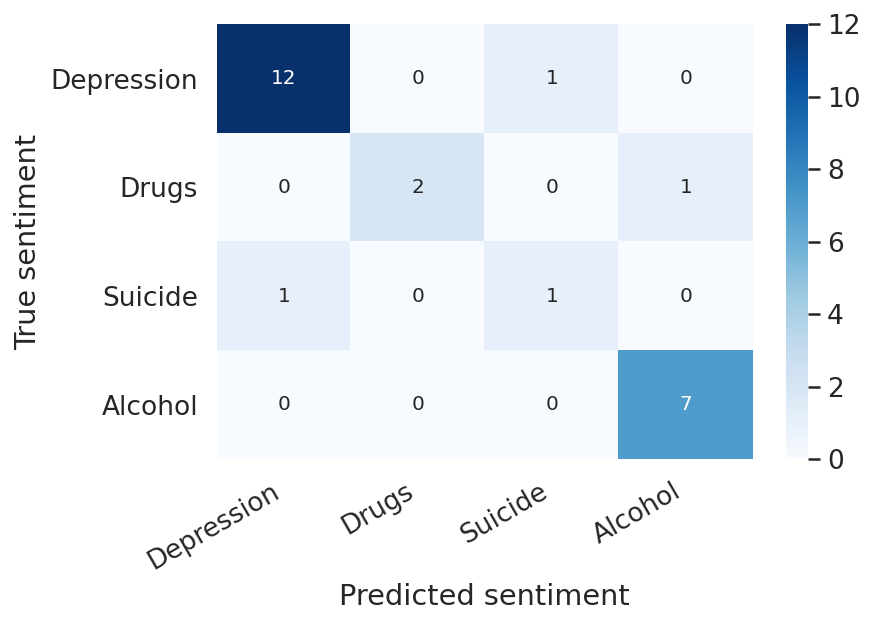

In [44]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [45]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [46]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

how better would i quit

True sentiment: Drugs


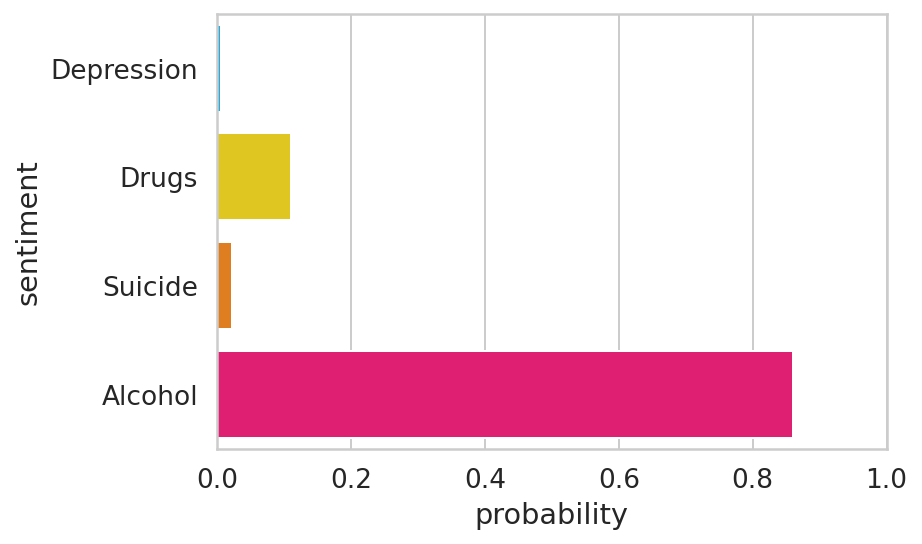

In [47]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [48]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, tokenizer, max_len):
    self.reviews = reviews
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
    }

In [49]:
def create_data_loader(test_set, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=test_set.text.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [50]:
test_set_loader = create_data_loader(test_set, tokenizer, MAX_LEN, BATCH_SIZE)

In [51]:
import torch.nn.functional as F
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  return review_texts, predictions, prediction_probs

In [52]:
test_review_texts, test_pred, test_pred_probs = get_predictions(
  model,
  test_set_loader
)

In [53]:
test_pred_probs.shape
preds = test_pred_probs

In [54]:
sub=pd.read_csv('/content/drive/My Drive/Zindi/SampleSubmission.csv')
sub.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0


In [55]:
sub['Depression']=preds[:,0]
sub['Alcohol']=preds[:,3]
sub['Suicide']=preds[:,2]
sub['Drugs']=preds[:,1]

In [57]:
sub.to_csv('results1.csv',index=False)